In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
keypoint_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 8
image_name = keypoint_frame.iloc[n, 0]
keypts = keypoint_frame.iloc[n, 1:].to_numpy()
keypts = keypts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', keypts.shape)
print('First 4 key pts: {}'.format(keypts[:4]))

Image name:  James_Hoffa_51.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 47. 101.]
 [ 47. 117.]
 [ 50. 132.]
 [ 50. 144.]]


In [3]:
# number of images
print('Number of images: ', keypoint_frame.shape[0])

Number of images:  3462


In [4]:
#to show Keypoint
def show_keypoints(image, keypts):
    plt.imshow(image)
    plt.scatter(keypts[:, 0], keypts[:, 1], s=20, marker='.', c='m')


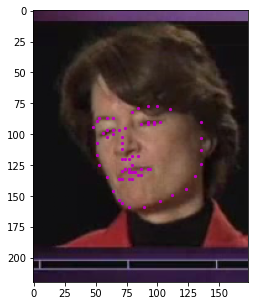

In [5]:
# selecting an image n from the dataset
n = 22
image_name = keypoint_frame.iloc[n, 0]
keypts = keypoint_frame.iloc[n, 1:].to_numpy()
keypts = keypts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), keypts)
plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader

#Facial keypoints dataset
class FacialKeypointsDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.keypoint_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.keypoint_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.keypoint_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        keypts = self.keypoint_frame.iloc[idx, 1:].to_numpy()
        keypts = keypts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': keypts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
# Constructing the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (240, 200, 3) (68, 2)
1 (262, 237, 3) (68, 2)
2 (360, 443, 3) (68, 2)


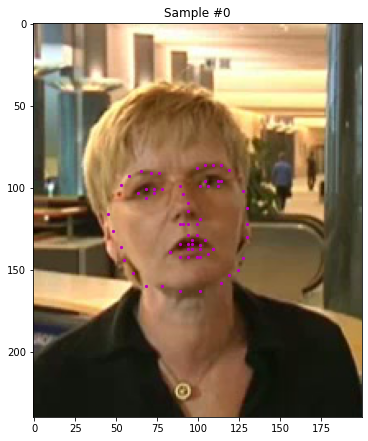

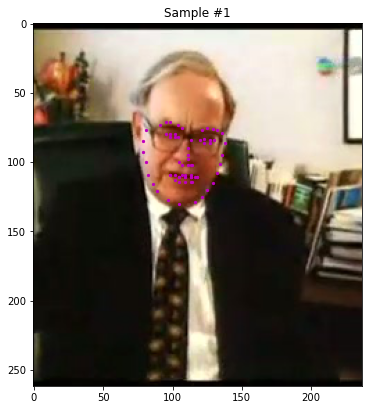

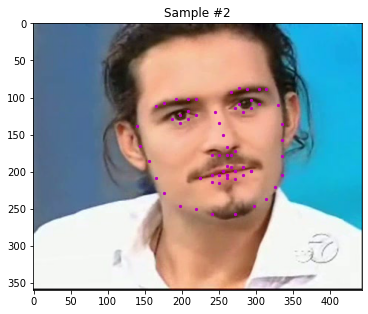

In [8]:
# Displaying a few of the images 
num_to_display = 3

for i in range(num_to_display):
    
    # defining the size of images
    fig = plt.figure(figsize=(20,10))
    
    # sample image
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # printing the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    

    show_keypoints(sample['image'], sample['keypoints'])


In [9]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    #converting image to grayscale       

    def __call__(self, sample):
        image, keypts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        keypts_copy = np.copy(keypts)

       
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scaling color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        keypts_copy = (keypts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': keypts_copy}


#rescaling images 
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, keypts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        keypts = keypts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': keypts}


class RandomCrop(object):
   #Cropping an image randomly

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, keypts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        keypts = keypts - [left, top]

        return {'image': image, 'keypoints': keypts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, keypts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypts)}

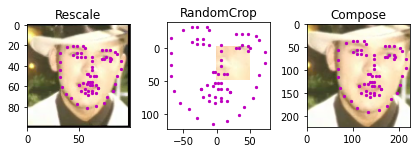

In [10]:
# testing transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

test_num = 200
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()



In [11]:
# defining the data tranform
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


In [12]:
from workspace_utils import active_session
%load_ext autoreload
%autoreload 2

In [13]:
#importing model
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=1024, out_features=136, bias=True)
)


In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([ Rescale(240), RandomCrop(224), Normalize(), ToTensor() ])

assert(data_transform is not None), 'Define a data_transform'

In [15]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [16]:
# load training data in batches
batch_size = 12

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [17]:
# loading the test data, using the dataset class
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [18]:
# loading test data in batches
batch_size = 12

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [19]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterating through the test dataset
    for i, sample in enumerate(test_loader):
        
        # getting sample data
        images = sample['image']
        keypts = sample['keypoints']

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        if i == 0:
            return images, output_pts, keypts
            

In [20]:
#function call
test_images, test_outputs, gt_pts = net_sample_output()

# printing out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([12, 1, 224, 224])
torch.Size([12, 68, 2])
torch.Size([12, 68, 2])


In [21]:
def show_all_keypoints(image, predicted_keypts, gt_pts=None):
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_keypts[:, 0], predicted_keypts[:, 1], s=20, marker='.', c='m')
    # plotting ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


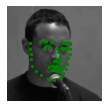

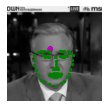

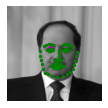

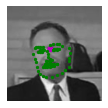

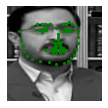

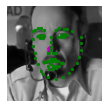

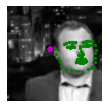

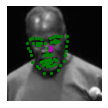

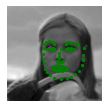

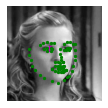

In [22]:
# visualizing the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   
        image = image.numpy()   
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted keypts data
        predicted_keypts = test_outputs[i].data
        predicted_keypts = predicted_keypts.numpy()
        # undo normalization of keypoints  
        predicted_keypts = predicted_keypts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_keypts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
visualize_output(test_images, test_outputs, gt_pts)

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [24]:
def train_net(n_epochs):

    # preparing the net for training
    net.train()

    for epoch in range(n_epochs):  # looping over the dataset multiple times
        
        running_loss = 0.0

        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            keypts = data['keypoints']

            
            keypts = keypts.view(keypts.size(0), -1)

            # convert variables to floats for regression loss
            keypts = keypts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, keypts)

            
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # printing loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [25]:
# train your network
n_epochs = 5 
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.34017650336027144
Epoch: 1, Batch: 20, Avg. Loss: 0.18385045900940894
Epoch: 1, Batch: 30, Avg. Loss: 0.16465295031666755
Epoch: 1, Batch: 40, Avg. Loss: 0.15934964939951896
Epoch: 1, Batch: 50, Avg. Loss: 0.16254386231303214
Epoch: 1, Batch: 60, Avg. Loss: 0.14119129553437232
Epoch: 1, Batch: 70, Avg. Loss: 0.16225054934620858
Epoch: 1, Batch: 80, Avg. Loss: 0.16215968281030654
Epoch: 1, Batch: 90, Avg. Loss: 0.14909985587000846
Epoch: 1, Batch: 100, Avg. Loss: 0.14811996147036552
Epoch: 1, Batch: 110, Avg. Loss: 0.15754949301481247
Epoch: 1, Batch: 120, Avg. Loss: 0.13803611174225808
Epoch: 1, Batch: 130, Avg. Loss: 0.1664164535701275
Epoch: 1, Batch: 140, Avg. Loss: 0.20896531119942666
Epoch: 1, Batch: 150, Avg. Loss: 0.15803856253623963
Epoch: 1, Batch: 160, Avg. Loss: 0.1256136603653431
Epoch: 1, Batch: 170, Avg. Loss: 0.14371699318289757
Epoch: 1, Batch: 180, Avg. Loss: 0.1602955497801304
Epoch: 1, Batch: 190, Avg. Loss: 0.13958616480231284
Epoch

In [26]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([12, 1, 224, 224])
torch.Size([12, 68, 2])
torch.Size([12, 68, 2])


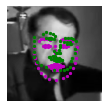

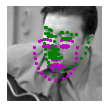

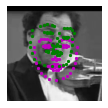

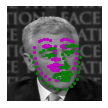

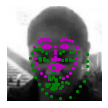

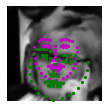

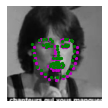

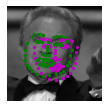

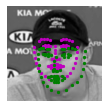

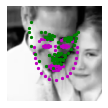

In [27]:
#visualize the output
visualize_output(test_images, test_outputs, gt_pts)


In [32]:

model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

torch.save(net.state_dict(), model_dir+model_name)

[[-0.09224369 -0.03569903 -0.20108934 -0.03919322  0.18521439]
 [-0.13143444  0.03441223  0.0878384   0.05962816 -0.03936351]
 [-0.11259114  0.01436953 -0.0415238   0.06173171 -0.1524822 ]
 [-0.01366532 -0.10813354 -0.16143323  0.02702912  0.1750551 ]
 [-0.08707207  0.15524663  0.00459308  0.1472436  -0.17975584]]
(5, 5)


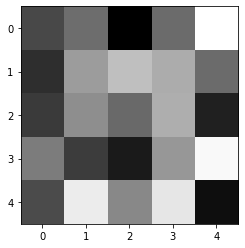

In [33]:
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# displaying the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


(224, 224)


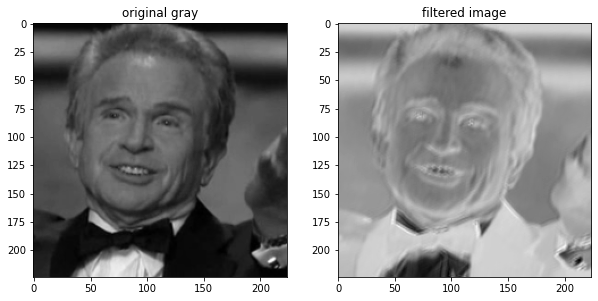

In [34]:
## applying a specific set of filter weights to test image
%matplotlib inline
imgNo= 7
myImage = np.squeeze(test_images[imgNo].data)
myImage = myImage.numpy()  
print(myImage.shape)
myFilter=w[filter_index][0]
filtered_image = cv2.filter2D(myImage, -1, myFilter)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('original gray')
ax1.imshow(myImage, cmap='gray')
ax2.set_title('filtered image')
ax2.imshow(filtered_image, cmap='gray')
